In [81]:
import mysql.connector as mariadb
import pandas as pd
import pandas.io.sql as psql
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

load_dotenv()

import re
import pdb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Connect to Database

In [17]:
db=mariadb.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    passwd=os.getenv("DB_PASS"),
    db=os.getenv("DB_NAME"))
query = "select title, body, date from {}".format(os.getenv("DB_TABLE_NAME"))
forum_titles_frame = psql.read_sql(query, con=db)
db.close()

### Data content and shape

In [36]:
forum_titles_frame.head()

,title,body,date
0,ayuda con fluidos no newtonianos,"hola a todos, una amiga necesita ayuda con un ...",2020-06-07 00:00:00
1,¿cómo recuperar la motivación para trabajar?,"dentro de esta etapa de confinamiento, donde s...",2020-06-07 00:00:00
2,[invitación] forma parte de un proyecto abiert...,hola compañeros y compañeras!!\njunto con un g...,2020-06-08 23:02:22
3,template latex,"hola, ya que el thread anterior se llenó, publ...",2020-06-04 00:00:00
4,ley que fortalece el sistema de inteligencia n...,de seguro algunos han visto algún artículo que...,2020-06-06 00:00:00


In [37]:
# pdb.set_trace()
forum_titles_frame.shape

(75666, 3)

In [38]:
forum_titles_frame.index

RangeIndex(start=0, stop=75666, step=1)

#### Map datestamp to year

In [39]:
titles_frame_mappedYear = forum_titles_frame[['date']].apply(lambda datestamp: datestamp.dt.year)
titles_frame_mappedYear[['title', 'body']] = forum_titles_frame[['title', 'body']]
titles_frame_mappedYear.head()

,date,title,body
0,2020,ayuda con fluidos no newtonianos,"hola a todos, una amiga necesita ayuda con un ..."
1,2020,¿cómo recuperar la motivación para trabajar?,"dentro de esta etapa de confinamiento, donde s..."
2,2020,[invitación] forma parte de un proyecto abiert...,hola compañeros y compañeras!!\njunto con un g...
3,2020,template latex,"hola, ya que el thread anterior se llenó, publ..."
4,2020,ley que fortalece el sistema de inteligencia n...,de seguro algunos han visto algún artículo que...


### Threads count per year

In [40]:
titles_frame_mappedYear_only_title = titles_frame_mappedYear[['date', 'title']]
titles_frame_mappedYear_only_title.groupby(['date']).count().loc[2011]

title    15503
Name: 2011, dtype: int64

In [41]:
count_titles = titles_frame_mappedYear_only_title.groupby(['date']).count()
count_titles.index

Int64Index([2002, 2003, 2006, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020],
           dtype='int64', name='date')

In [43]:
selected_years_mask = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
#count_titles.loc[(count_titles.index > 2008) & (count_titles.index < 2020)]
count_titles.columns = ['thread_count']
count_titles.index.name = 'year'
last_decade_titles_count = count_titles.loc[count_titles.index * selected_years_mask > 0]
last_decade_titles_count

,thread_count
year,
2010,5307
2011,15503
2012,11256
2013,8833
2014,6194
2015,6484
2016,5652
2017,5386
2018,5042


### Word clouds: total and yearly

#### Lemmatizer and Stopwords

In [100]:
resource_file = 'lemmatization-es.txt'
lemmatiser_es = lemmatiser(create_lemma_dict(resource_file))

In [101]:
stopwords_from_file = np.genfromtxt('stopwords_es.txt', dtype='str', delimiter='\n', encoding='utf-8')
stopwords_from_file = formatStrings(pd.Series(stopwords_from_file))

stopwords_es = stopwords.words('spanish') 
stopwords_es = set.union(set(map(cleanSingleString, stopwords_es)), stopwords_from_file)

#### Only titles vs titles and body message

In [102]:
mergedTitlesAndBody = formatAndMergeStringsFromSeries(forum_titles_frame["title"] + " " + forum_titles_frame["body"])
onlyTitles = formatAndMergeStringsFromSeries(forum_titles_frame["title"])
mergedTitlesAndBody[0:200]

'ayuda con fluidos no newtonianos hola a todos una amiga necesita ayuda con un tema de fluidos no newtonianos a mi juicio es un tema basico sobre calcular la velocidad radial en un tubo de pitot si alg'

#### Total word cloud: merged titles and body

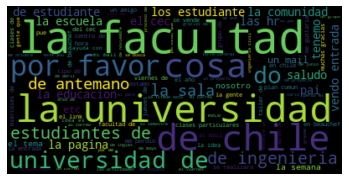

In [103]:
plotWordCloud(mergedTitlesAndBody, stopwords_es)

#### Total word cloud: only titles

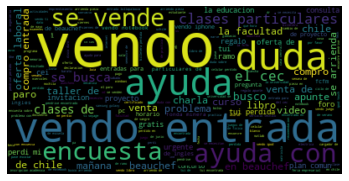

In [104]:
plotWordCloud(onlyTitles, stopwords_es)

#### Yearly word clouds

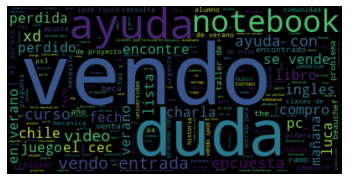

Year: 2010, titles only


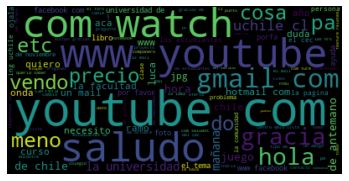

Year: 2010, titles and body


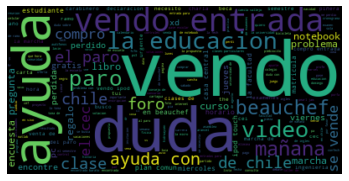

Year: 2011, titles only


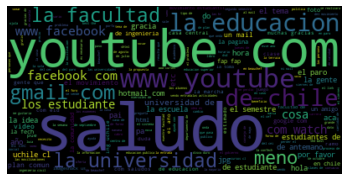

Year: 2011, titles and body


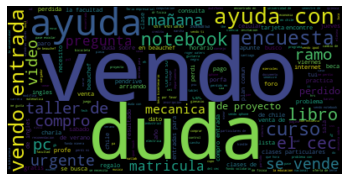

Year: 2012, titles only


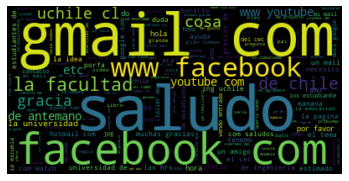

Year: 2012, titles and body


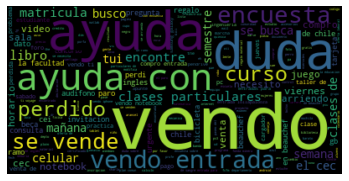

Year: 2013, titles only


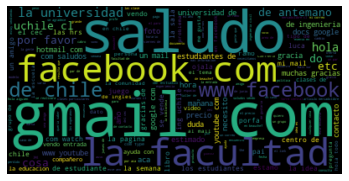

Year: 2013, titles and body


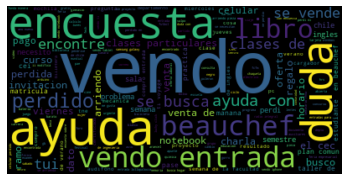

Year: 2014, titles only


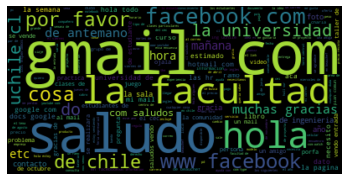

Year: 2014, titles and body


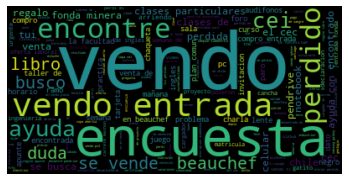

Year: 2015, titles only


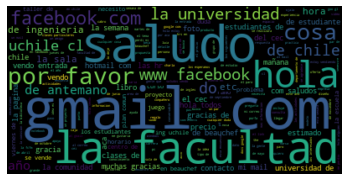

Year: 2015, titles and body


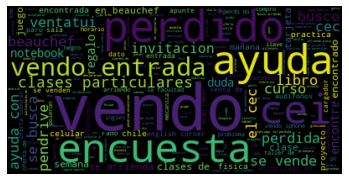

Year: 2016, titles only


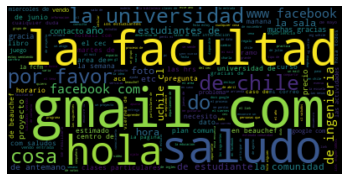

Year: 2016, titles and body


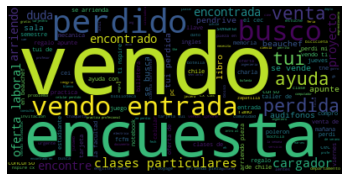

Year: 2017, titles only


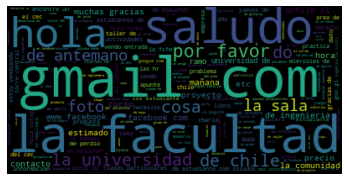

Year: 2017, titles and body


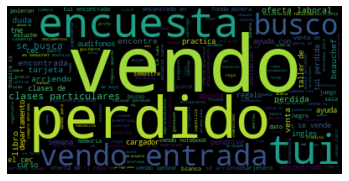

Year: 2018, titles only


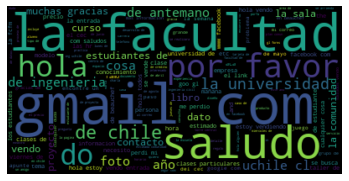

Year: 2018, titles and body


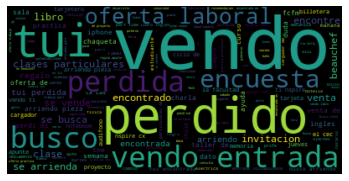

Year: 2019, titles only


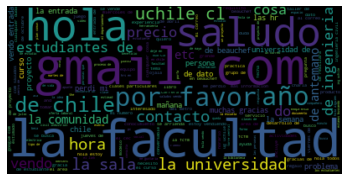

Year: 2019, titles and body


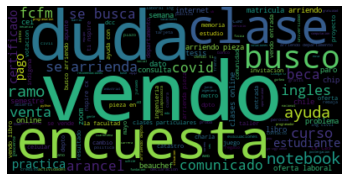

Year: 2020, titles only


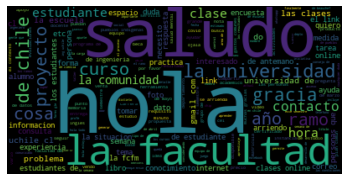

Year: 2020, titles and body


In [70]:
for year in last_decade_titles_count.index:
    titles_from_year = forum_titles_frame[titles_frame_mappedYear['date'] == year]
    mergedText = formatAndMergeStringsFromSeries(titles_from_year["title"])
    plotWordCloud(mergedText, stopwords_es)
    print("Year: {}, titles only".format(year))
    mergedWithBody = formatAndMergeStringsFromSeries(titles_from_year["title"] + " " + titles_from_year["body"])
    plotWordCloud(mergedWithBody, stopwords_es)
    print("Year: {}, titles and body".format(year))

### Threads about mental health

#### init lemmatizer

In [273]:
mental_health_keywords = ['ansiedad', 'desmotivación', 'estres', 'concentracion', 'deprimido', 'depresion',
                             'animo', 'psicologica', 'mental', 'siquiatra', 'psicóloga', 'motiva', 'autocuidado',
                             'bienestar', 'frustración']
mental_health_lemmas = set(map(lemmatiser_es, map(cleanSingleString, mental_health_keywords)))

def lemmatizeSentence(sentence):
    return " ".join(map(lemmatiser_es, sentence.split(" ")))

def cleanAndLemmatizeTitles(titleSerie):
    return formatStrings(titleSerie).transform(lemmatizeSentence)

def isTopicOfInterest(sentenceSeries):
    return sentenceSeries.transform(lambda sentence: 1 if any(map(lambda word: word in mental_health_lemmas, sentence.split(" "))) else 0)

titles_mapped = forum_titles_frame[['title']].apply(cleanAndLemmatizeTitles).apply(isTopicOfInterest)
titles_mapped[['date']] = forum_titles_frame[['date']].reset_index(drop=True)
titles_mapped.head()

,title,date
0,0,2020
1,0,2020
2,0,2020
3,0,2020
4,0,2020


In [274]:
titles_mapped.groupby(['date']).sum()

,title
date,
2002,0
2003,0
2006,0
2007,0
2008,0
2009,25
2010,18
2011,28
2012,45


In [94]:
def formatStrings(strings):

    strings = strings.transform(cleanSingleString)

    # todo a minusculas
    strings = pd.Series(list(map(lambda x: x.lower(), strings)))
    
    return strings

def cleanSingleString(word):
    tildes = ['á','é','í','ó','ú']
    vocales = ['a','e','i','o','u']

    # tildes
    for idx, vocal in enumerate(vocales):
        word = word.replace(tildes[idx],vocal)

    # borrar caracteres especiales menos la ñ
    return re.sub('[^A-Zña-z0-9 ]+', '', word)

In [95]:
def obtainMergedStringsFromSeries(dataSeries):
    return " ".join(dataSeries)

In [96]:
def formatAndMergeStringsFromSeries(dataSeries):
    return obtainMergedStringsFromSeries(formatStrings(dataSeries))

In [97]:
def plotWordCloud(text, stopwords):
    wordcloud = WordCloud(stopwords=stopwords).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [98]:
def lemmatiser(dict):
    def lookup(word):
        try:
            lemma = dict[word]
        except:
            lemma = word
        
        return lemma
    
    return lookup

In [99]:
def create_lemma_dict(filename):
   with open(filename, 'r', encoding="utf-8") as document:
       lemma_dict = {}
       for line in document:
           if line.strip():  # avoid empty lines
               value, key = line.split(None, 1) # 'None' means 'all whitespace', which is the default
               key = cleanSingleString(key.rstrip()) # rstrip() to get rid of \r and \n
               value = cleanSingleString(value)
               lemma_dict[key] = value # adding the flections as keys to the dict
               lemma_dict[value] = value # adding also the base word as a key
   return lemma_dict